In [ ]:
# https://zhuanlan.zhihu.com/p/429847479
#
# 研究区被离散化为 32 列，40 行，每个单元格均为 50m × 50m，高程为 10m，厚度为 10m 的承压含水层。
# 模型东西两侧无流量。南北均是指定水头边界，其中北部水头值为 250m，南部水头值为 36.25m。
# 研究区共有两口井，井 A (9, 15) 往地下水中注入指定浓度 (57.87 ppm) 的水体，注水速率为 0.001m3/s (折合: 86.4m3/d)；另有井 B (23, 15) 进行抽水，抽水速率为 -0.0189m3/s (折合: 1632.96m3/d)。
# 在两口井的中间，存在一个渗透性较低的区域（见下图），渗透系数较其他区域 (1.474 × 10^(-4))m/s (折合: 12.7m/d) 低三个数量级 (1.474 × 10^(-7))m/s (折合: 0.0127m/d)。
# 研究区孔隙率为 0.3，纵向弥散度为 20m，横向弥散度与纵向弥散度之比为 0.2。
# 模拟时间为 365 天。

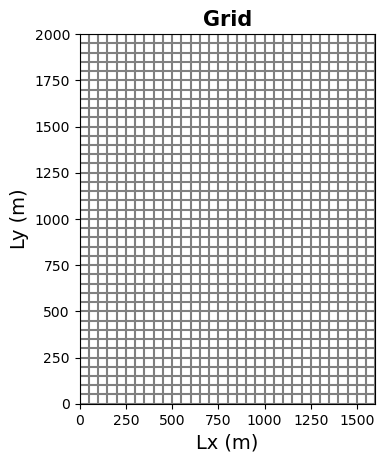

FloPy is using the following executable to run the model: ..\..\..\..\AppData\Local\flopy\bin\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: mf.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2024/05/30 21:11:56

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:

Text(0.5, 1.0, 'Flow Direction')

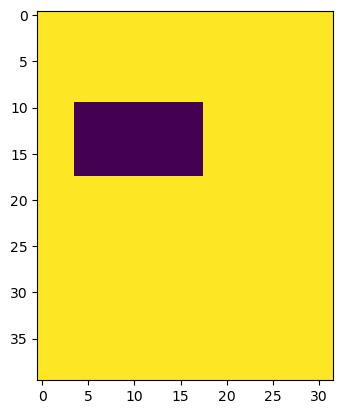

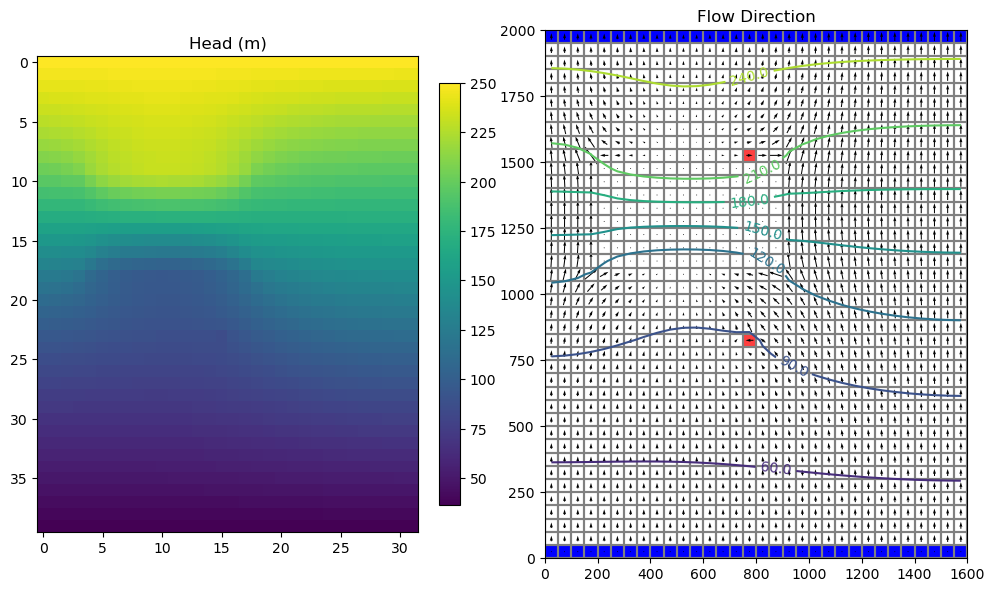

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import flopy


# MODFLOW
mf = flopy.modflow.Modflow(modelname = 'mf', exe_name= 'mf2005.exe', model_ws = './IdealModel3')
# DIS
Lx = 1600
Ly = 2000
nrow = 40
ncol = 32
nlay = 1
delr = Lx / ncol
delc = Ly / nrow
ztop = 10
zbot = 0
botm = np.linspace(ztop, zbot, nlay + 1)
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr = delr, delc = delc, top = ztop, 
                               botm = botm[1:],perlen = 365, nstp = 30, itmuni = 4)


# 可以使用flopy自带的函数查看建模结果###########################
modelmap = flopy.plot.PlotMapView(model=mf, layer=0)
grid = modelmap.plot_grid()
plt.xlabel("Lx (m)", fontsize=14)
plt.ylabel("Ly (m)", fontsize=14)
plt.title("Grid", fontsize=15, fontweight="bold")
plt.show()
###########################

# BAS
ibound = np.ones((nlay, nrow, ncol), dtype = np.int32)
ibound[0, 0, :] = -1
ibound[0, -1, :] = -1
# ibound[0, 1:-1, 0] = 0
# ibound[0, 1:-1, -1] = 0
strt = 145 * np.ones((nlay, nrow, ncol), dtype = np.float32)
strt[0, 0, :] = 250
strt[0, -1, :] = 36.25
bas = flopy.modflow.ModflowBas(mf, ibound = ibound, strt = strt)


# LPF
laytyp = 0
hk = np.ones((nlay, nrow, ncol), dtype=np.float32)
hk[:, :, :]  = 12.7 # 1.474 * (10 ** (-4))
hk[:, 10:18, 4:18]  = 0.0127 # 1.474 * (10 ** (-7))
lpf = flopy.modflow.ModflowLpf(mf, hk = hk, vka = hk, laytyp = laytyp, ipakcb = 1)
###########
plt.imshow(hk[0])
################
# WEL
wel_spd = {0: [[0, 9, 15, 86.4], [0, 23, 15, -1633.0]]}
wel = flopy.modflow.ModflowWel(mf, stress_period_data = wel_spd)


# OC
oc_spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}
oc = flopy.modflow.ModflowOc(mf, stress_period_data = oc_spd, compact = True)
# PCG
pcg = flopy.modflow.ModflowPcg(mf)
# LMT
lmt = flopy.modflow.ModflowLmt(mf, output_file_name='mt3d_link.ftl')
# write
mf.write_input()
# run
success, mfoutput = mf.run_model(pause = False, report = True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

headobj = flopy.utils.binaryfile.HeadFile("./IdealModel3/mf" + ".hds")
budgobj = flopy.utils.binaryfile.CellBudgetFile("./IdealModel3/mf" + ".cbc")
head = headobj.get_data()[0]
frf = budgobj.get_data(text="FLOW RIGHT FACE")[0]
fff = budgobj.get_data(text="FLOW FRONT FACE")[0]

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(1, 2, 1)
head_p = ax1.imshow(head)
plt.title("Head (m)")
plt.colorbar(head_p, fraction=0.05, pad=0.05)

ax2 = fig.add_subplot(1, 2, 2)
modelmap = flopy.plot.PlotMapView(model=mf, layer=0)
grid = modelmap.plot_grid()
qm = modelmap.plot_ibound()
lc = modelmap.plot_grid()
qm = modelmap.plot_bc("WEL", alpha=0.5)
quiver = modelmap.plot_vector(frf, fff)
cs = modelmap.contour_array(head)
plt.clabel(cs, inline=1, fmt="%1.1f")
plt.title("Flow Direction")

In [11]:

# MT3DMS #################################################################
mt = flopy.mt3d.Mt3dms(modelname = 'mt', version = 'mt3dms', 
                       modflowmodel = mf, model_ws = './IdealModel3')
# BTN
icbund = np.ones((nlay, nrow, ncol))
btn = flopy.mt3d.Mt3dBtn(mt, sconc = 0, prsity = 0.3, thkmin = 0.01, tunit = 'D',munit = 'ppm',
                         nprs = 5, timprs = [0,20,60,120,360], icbund = icbund)
# ADV
adv = flopy.mt3d.Mt3dAdv(mt,mixelm = -1, percel = 1)
# DSP
dsp = flopy.mt3d.Mt3dDsp(mt, al = 20, dmcoef = 0, trpt = 0.2, trpv = 0.01)
# SSM
ssm_data = {}
ssm_data[0] = [(0, 9, 15, 57.87, 2)]
ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data = ssm_data)
# GCG
gcg = flopy.mt3d.Mt3dGcg(mt, mxiter = 1, iter1 = 50, isolve = 1, cclose = 0.0001)
mt.write_input()
mt.run_model()



FloPy is using the following executable to run the model: ..\..\..\..\AppData\Local\flopy\bin\mt3dms.exe
 MT3DMS - Modular 3-D Multi-Species Transport Model [Version 5.30]
 Developed at University of Alabama for U.S. Department of Defense

 Using NAME File: mt.nam                                            

 STRESS PERIOD NO.    1

 TIME STEP NO.    1
 FROM TIME =   0.0000     TO    12.167    

 Transport Step:    1   Step Size:   0.000     Total Elapsed Time:   0.0000    
 Transport Step:    2   Step Size:   2.814     Total Elapsed Time:   2.8135    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   1.639      [K,I,J]    1   10   16
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1028      [K,I,J]    1   10   17
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.8232E-02  [K,I,J]    1   10   18
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.8087E-03  [K,I,J]    1   10   19
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1177E-03  [K,I,J]    1   11   19
 Outer Iter.  1  Inner Iter.  6:  Max. DC

(False, [])

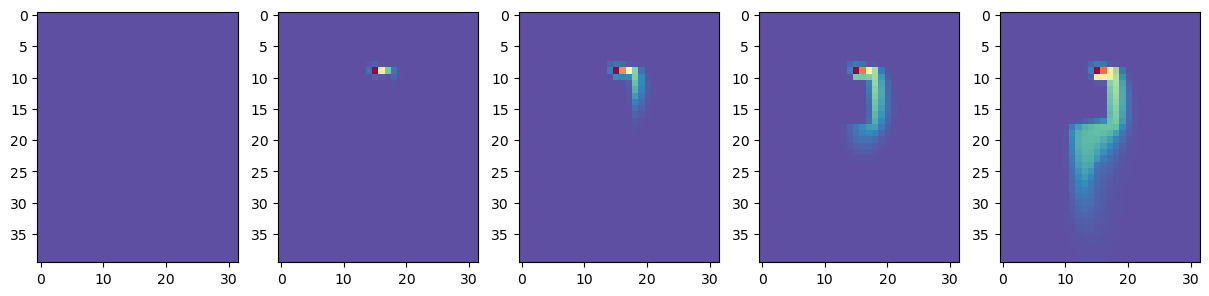

In [12]:
conc = flopy.utils.UcnFile("./IdealModel3/MT3D001.UCN")
times = conc.get_times()
conc = conc.get_alldata()

fig = plt.figure(figsize=(15, 60))
ax = [i for i in range(10)]
for i in range(5):
    ax[i] = fig.add_subplot(1, 5, i + 1)
    ax[i].imshow(conc[i, 0], cmap="Spectral_r")